# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/nishanth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nishanth/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

mkdir: data: File exists


In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31524    0 31524    0     0  62748      0 --:--:-- --:--:-- --:--:-- 62796


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70549    0 70549    0     0   171k      0 --:--:-- --:--:-- --:--:--  171k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [8]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [9]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [10]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [11]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [15]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/13 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/16 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 9, relationships: 25)

We can save and load our knowledge graphs as follows.

In [16]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 9, relationships: 25)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [18]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

SingleHopSpecificQuerySynthesizer:

Generates simple, direct questions based on a single piece of information or node in the knowledge graph.
Example: "What is the main theme of the 2023 blog?"

MultiHopAbstractQuerySynthesizer:

Creates abstract or generalized questions that require combining information from multiple nodes in the knowledge graph.
Example: "How has the use of AI evolved between 2023 and 2024?"

MultiHopSpecificQuerySynthesizer:

Produces specific, detailed questions that require connecting multiple pieces of information across nodes in the knowledge graph.
Example: "What are the key differences in AI advancements mentioned in the 2023 and 2024 blogs?"





Finally, we can use our `TestSetGenerator` to generate our testset!

In [19]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What are the key developments and challenges r...,[My blog in 2023 Here’s the sequel to this pos...,"In 2024, significant progress has been made in...",single_hop_specifc_query_synthesizer
1,How is Python relevant to the challenges faced...,[openly licensed ones are still the world’s mo...,Python is mentioned in the context of code gen...,single_hop_specifc_query_synthesizer
2,Considering the advancements in Artificial Int...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"In 2023, Large Language Models (LLMs) marked a...",single_hop_specifc_query_synthesizer
3,How does the term GPT relate to the latest adv...,"[of what LLMs are, how they work and how they ...",The context discusses GPT as a significant com...,single_hop_specifc_query_synthesizer
4,Wha is the real meaning of China in the contex...,[The rise of inference-scaling “reasoning” mod...,The context discusses China as part of the lan...,single_hop_specifc_query_synthesizer
5,How do advancements in multimodal AI capabilit...,[<1-hop>\n\nThe rise of inference-scaling “rea...,"Advancements in multimodal AI capabilities, in...",multi_hop_abstract_query_synthesizer
6,How do recent advancements in large language m...,[<1-hop>\n\nThe rise of inference-scaling “rea...,Recent advancements in large language models (...,multi_hop_abstract_query_synthesizer
7,How does the increased context length in LLMs ...,[<1-hop>\n\nThe rise of inference-scaling “rea...,The context length in LLMs has significantly i...,multi_hop_abstract_query_synthesizer
8,How do GPT-4V and GPT-4 compare in terms of th...,[<1-hop>\n\nThe rise of inference-scaling “rea...,GPT-4V represents the latest in GPT-4's evolut...,multi_hop_specific_query_synthesizer
9,"How do advancements in GPT-4, such as multimod...","[<1-hop>\n\nof what LLMs are, how they work an...",The context highlights that GPT-4 has broken p...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [20]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'StringIO' object has no attribute 'output'


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [31]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is Llama in the context of large language...,[My blog in 2023 Here’s the sequel to this pos...,Llama is a large language model that was relea...,single_hop_specifc_query_synthesizer
1,What insights does the New York Times provide ...,[openly licensed ones are still the world’s mo...,The New York Times launched a landmark lawsuit...,single_hop_specifc_query_synthesizer
2,How do you spell GPT-4?,[Simon Willison’s Weblog Subscribe Stuff we fi...,The context discusses GPT-4 but does not speci...,single_hop_specifc_query_synthesizer
3,"How do Large Language Models (LLMs) work, and ...","[of what LLMs are, how they work and how they ...",Large Language Models (LLMs) are complex AI sy...,single_hop_specifc_query_synthesizer
4,How the AI research history and development of...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,The historical context of AI research shows th...,multi_hop_abstract_query_synthesizer
5,Wht are the main misconceptions about AI syste...,[<1-hop>\n\nways we should not be using genera...,The context highlights that many misconception...,multi_hop_abstract_query_synthesizer
6,How do LLMs and AI developement in 2024 show t...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, the field of Large Language Models (L...",multi_hop_abstract_query_synthesizer
7,how development of LLMs and legal challenges l...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,The context explains that 2023 was a big year ...,multi_hop_abstract_query_synthesizer
8,what is Llama 2 and how it relate to Llama in ...,"[<1-hop>\n\nof what LLMs are, how they work an...",Llama 2 is a version of the Llama large langua...,multi_hop_specific_query_synthesizer
9,How does the use of synthetic data in training...,[<1-hop>\n\nways we should not be using genera...,Recent discussions highlight that synthetic da...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [24]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years2!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [26]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [27]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [29]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [30]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [31]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [32]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [33]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [36]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [37]:
rag_chain.invoke({"question" : "What are Agents?"})

'Based on the provided context, "agents" is an infuriatingly vague term in AI that lacks a single, clear, and widely understood meaning. Generally, it refers to AI systems that can act on your behalf, but definitions vary widely. Two main understandings are:  \n\n1. AI agents as systems that "go and act on your behalf" in a way similar to a travel agent.  \n2. Large Language Models (LLMs) equipped with access to tools which they can use iteratively to solve problems.  \n\nDespite ongoing discussion and excitement about AI agents, few if any production-ready examples currently exist, partly due to issues like LLM gullibility and the difficulty of creating robust autonomous systems. Some believe fully effective agents depend on achieving Artificial General Intelligence (AGI), which may still be far off.  \n\nIn summary, "agents" generally means AI systems that perform tasks autonomously on behalf of users, but the term is not yet well-defined or realized in practice.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [38]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [41]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

ANSWER:

qa_evaluator: Evaluates the accuracy by comparing the predicted answer to the reference answer.

labeled_helpfulness_evaluator: Checks how helpful the response is to the user, considering the correctness and relevance of the answer compared to the reference.

dope_or_nope_evaluator: Evaluates the "coolness" or creativity of the response, determining if it is engaging, interesting, or "dope."

## LangSmith Evaluation

In [43]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'only-rose-45' at:
https://smith.langchain.com/o/81331f7e-618b-56fe-ae3d-28378bfd1e28/datasets/51329362-e644-4c85-9509-5330386ee3bd/compare?selectedSessions=e6665185-9d8b-4a93-856c-4b1ade203ef3




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How do ChatGPT and other LLMs demonstrate both...,"In 2024, ChatGPT and other LLMs continue to sh...",None,"In 2024, ChatGPT and other large language mode...",1,1,0,5.178208,9ce5136d-bcfd-4c47-85b8-b54a6b32a560,68124c58-6cb0-4020-baf0-80435d86c016
1,"How does googl's recent advancments in LLMs, l...","Based on the context, Google's recent advancem...",None,"In 2024, Google has made significant advanceme...",1,0,0,4.906620,cafeec46-5c74-498a-becb-38584737c7fc,b15dc1f6-b21b-4d33-a90e-1a28a818b3da
2,Considering the recent developments in Large L...,I don't know.,None,The context indicates that Google released Gem...,0,0,0,0.948870,c3180236-51c6-4457-a445-75a4d2895a5d,c76bb6cc-3d58-4513-bf9c-b8ccd585335a
3,How does the discussion of Qwen relate to the ...,"Based on the provided context, the discussion ...",None,The context highlights Qwen as part of the rec...,1,1,0,5.217524,0f916ac4-3212-469e-989d-00503f55e2fc,8f6570f5-0fff-470b-929b-f07b869636da
4,so like in 2024 what big advancments in LLMs l...,"In 2024, significant advancements in Large Lan...",None,"In 2024, a lot of advancements in Large Langua...",1,1,0,6.557238,027c7c2c-44dd-40dd-a161-a0052a97fabe,fd5b43f3-23a5-4870-9758-39acfdda4a6a
5,"Hw do multimodal capabilties like vision, audi...","In 2024, multimodal capabilities in LLMs—such ...",None,"In 2024, multimodal capabilties such as vision...",1,0,0,5.019415,c1b71d4b-a9d3-4c3a-8561-e5b7c462b435,8fe1d368-ad3d-408b-b690-6e003154d40a
6,How does the market compitition drivng AI inov...,I don't know,None,"In 2024, increased market competition has led ...",0,0,0,0.905791,f870cfdf-56e4-4199-86c3-6aa9c258b78c,0394eeca-b734-4add-bbba-50d1d43b0733
7,Considering the environmental impact and energ...,"Based on the provided context, recent advancem...",None,"Recent advancements in large language models, ...",1,1,0,2.699395,64f6413c-1c6b-4fde-b47f-d2b08c879f6a,21e18c73-b3f2-475b-bdcf-fbb86d17e30e
8,How does OpenAI influence the development and ...,"Based on the provided context, OpenAI has play...",None,The context highlights that OpenAI is a signif...,1,1,0,6.688167,d738fd41-cc63-42f4-80f1-622cd59a38da,f1318050-464b-40c5-a9bb-9677c8565e4c
9,What are Large Language Models and why are the...,Large Language Models (LLMs) are software syst...,None,Large Language Models are a recent development...,1,1,0,6.137339,23ded86a-619e-4c25-9c9f-26a1d42ba8ba,8f3a5dda-f610-4307-a47a-9c45f5632799


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [44]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [45]:
rag_documents = docs

In [46]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

ANSWER:

Modifying the chunk size can impact the performance of the application because:

Context Coverage: Larger chunks allow more context to be included in a single query, which can improve the relevance of retrieved information. However, excessively large chunks may dilute the focus or exceed token limits.

Granularity: Smaller chunks provide finer granularity, which can help retrieve highly specific information. However, this may lead to fragmented context, making it harder to answer complex queries.

Embedding Quality: The quality of embeddings depends on the chunk size. Larger chunks may capture broader semantic meaning, while smaller chunks focus on specific details.

Retrieval Efficiency: Larger chunks reduce the number of chunks to search, improving retrieval speed. However, smaller chunks increase the number of candidates, potentially improving precision but at the cost of efficiency.

Summary:  the chunk size must balance context richness, retrieval precision, and computational efficiency to optimize application performance.



In [47]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

ANSWER:

Modifying the embedding model can impact the performance of the application because:

Embedding Quality: Different embedding models have varying levels of quality in capturing semantic relationships. A more advanced model (e.g., text-embedding-3-large) can better represent the meaning of text, leading to more accurate retrieval of relevant documents.

Dimensionality: Larger embedding models often produce higher-dimensional embeddings, which can capture more nuanced features of the text. This can improve the precision of similarity calculations during retrieval.

Domain-Specific Performance: Some embedding models are trained on specific datasets or tasks, making them more effective for certain types of queries or content.

Generalization: Advanced models may generalize better across diverse queries, improving the overall robustness of the application.

In summary, a better embedding model enhances the retrieval process, leading to more relevant context for answering questions, which improves the application's performance.

In [48]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [49]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [50]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [51]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Alright, here’s the 411 on “Agents.” The term’s kinda like that mysterious kid on the block—everyone’s hyped but nobody’s really pinned down what it means exactly. Basically, “agents” usually refer to AI systems that can roll out and act on your behalf, like a digital travel agent booking your trips or an LLM running tools in a loop to solve problems.\n\nBut here’s the catch: the definition is all over the place. Some folks think of agents as fully autonomous AI homies making decisions, while others see them as just fancy tool-runners. The big drama? Gullibility. These AI agents tend to believe everything they hear, which messes with their ability to make solid decisions. Without beating that gullibility game—something maybe only AGI (Artificial General Intelligence) can fix—we’re kinda stuck in “coming soon” purgatory. So yeah, agents are like the cool future squad that’s not quite ready to show up yet.'

Finally, we can evaluate the new chain on the same test set!

In [52]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'best-van-46' at:
https://smith.langchain.com/o/81331f7e-618b-56fe-ae3d-28378bfd1e28/datasets/51329362-e644-4c85-9509-5330386ee3bd/compare?selectedSessions=54368edf-e482-42a5-907a-469e260d97f2




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How do ChatGPT and other LLMs demonstrate both...,"Alright, here's the lowdown on ChatGPT and the...",None,"In 2024, ChatGPT and other large language mode...",1,1,1,5.016586,9ce5136d-bcfd-4c47-85b8-b54a6b32a560,ef9eb3e5-05c0-446d-96f5-2ffc7e3058a3
1,"How does googl's recent advancments in LLMs, l...","Yo, check this out! Google’s Gemini 1.5 Flash ...",None,"In 2024, Google has made significant advanceme...",1,1,1,6.549888,cafeec46-5c74-498a-becb-38584737c7fc,76a66802-d671-43e7-8197-b49819bc9ea7
2,Considering the recent developments in Large L...,"Yo, here’s the lowdown straight from the conte...",None,The context indicates that Google released Gem...,0,0,1,4.813329,c3180236-51c6-4457-a445-75a4d2895a5d,42d1b7fc-e4d5-4f77-84fe-37315e4283e9
3,How does the discussion of Qwen relate to the ...,"Alright, here’s the lowdown: Qwen, rolled out ...",None,The context highlights Qwen as part of the rec...,1,1,1,4.299849,0f916ac4-3212-469e-989d-00503f55e2fc,122e93a2-1a46-4481-a64a-091ff6408823
4,so like in 2024 what big advancments in LLMs l...,"Yo, let me break it down for you fresh from th...",None,"In 2024, a lot of advancements in Large Langua...",1,1,1,6.241311,027c7c2c-44dd-40dd-a161-a0052a97fabe,32c2ec0f-383a-4bd0-a785-a261a22e0fcf
5,"Hw do multimodal capabilties like vision, audi...","Alright, here’s the lowdown, fresh and fly fro...",None,"In 2024, multimodal capabilties such as vision...",1,0,1,11.203031,c1b71d4b-a9d3-4c3a-8561-e5b7c462b435,7fe26579-45e2-46b1-8e1b-573ade24244f
6,How does the market compitition drivng AI inov...,"Yo, here’s the 411 based on the vibe from the ...",None,"In 2024, increased market competition has led ...",1,1,1,3.271604,f870cfdf-56e4-4199-86c3-6aa9c258b78c,7a70bc91-59ea-4c7c-a786-11136a85db24
7,Considering the environmental impact and energ...,"Yo, let me break it down for you—based on the ...",None,"Recent advancements in large language models, ...",1,1,1,4.296067,64f6413c-1c6b-4fde-b47f-d2b08c879f6a,1c9d61d4-e585-45c3-8d2f-2a253bffbbf5
8,How does OpenAI influence the development and ...,"Alright, here’s the lowdown on OpenAI’s vibe i...",None,The context highlights that OpenAI is a signif...,1,0,1,7.758529,d738fd41-cc63-42f4-80f1-622cd59a38da,b521d51e-0cb0-4de6-b364-1447a558db24
9,What are Large Language Models and why are the...,"Yo, check it — Large Language Models (LLMs) ar...",None,Large Language Models are a recent development...,1,0,1,4.817900,23ded86a-619e-4c25-9c9f-26a1d42ba8ba,7365e533-81a6-40d1-bc37-9dac55140018


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

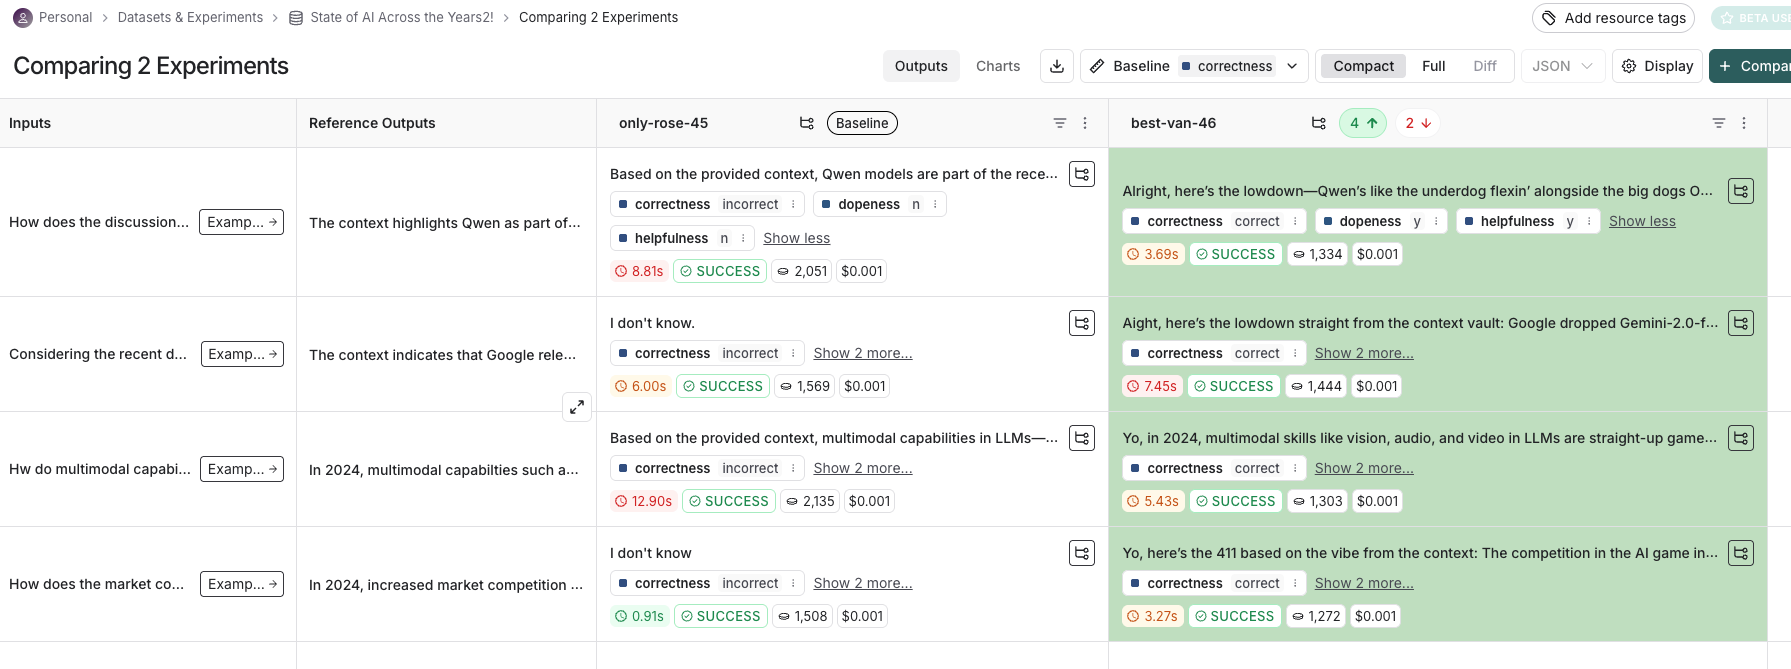

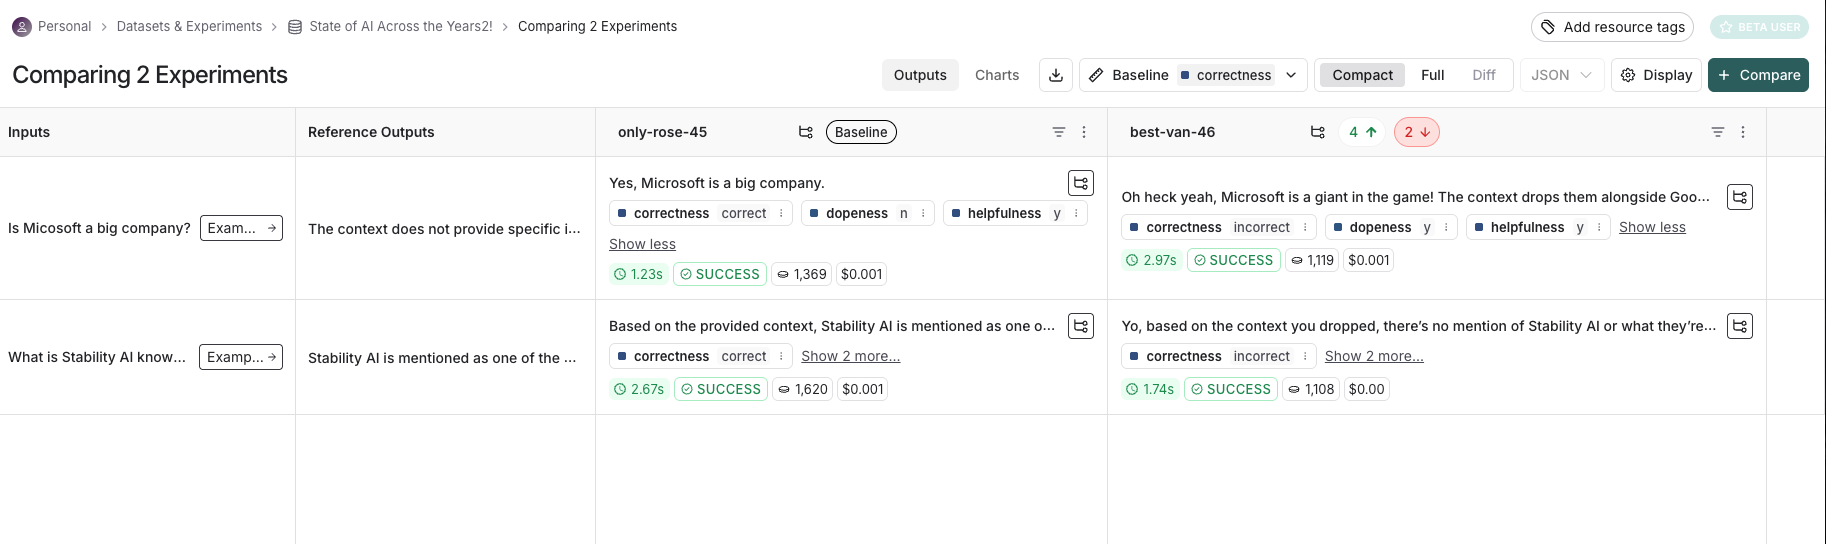